In [1]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [3]:
from zipfile import ZipFile
data_path = 'lung data.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')


The data set has been extracted.


In [4]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes



['lung_aca', 'lung_n', 'lung_scc']

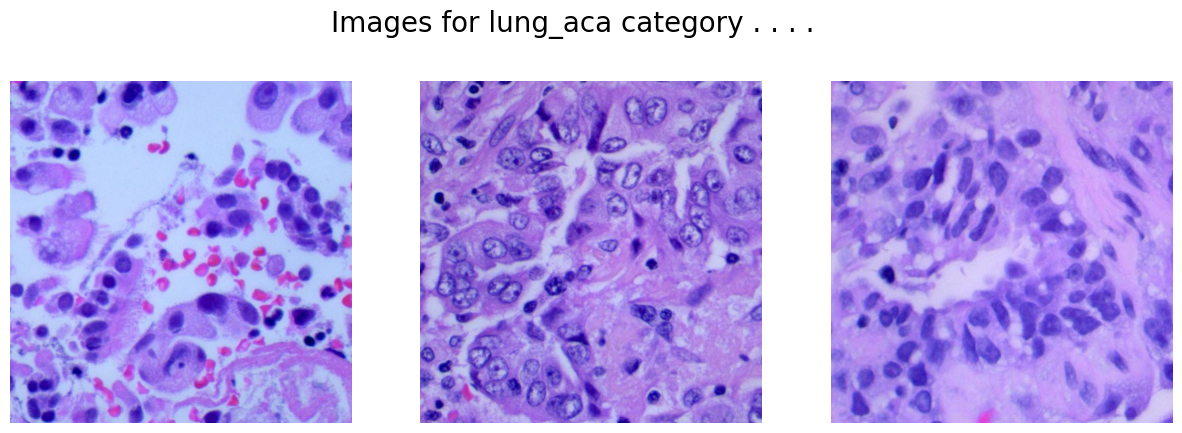

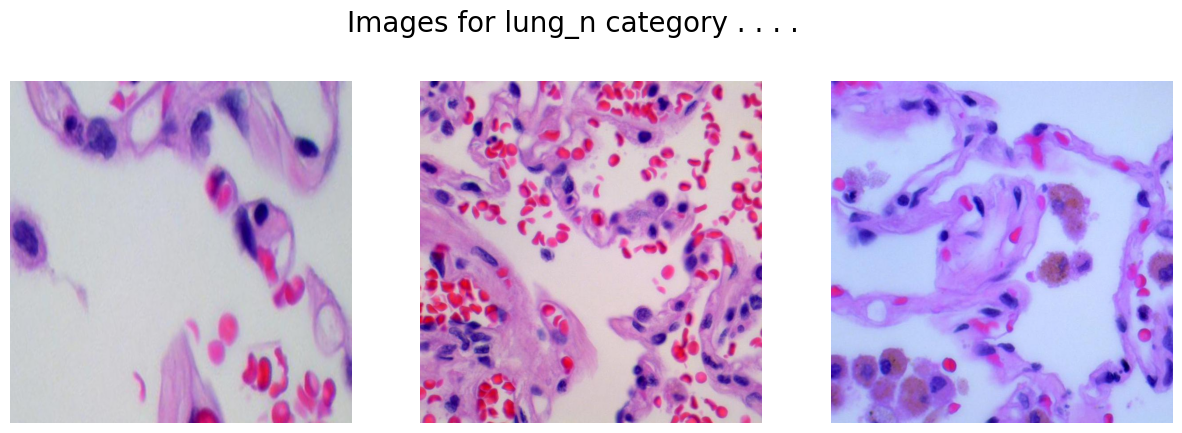

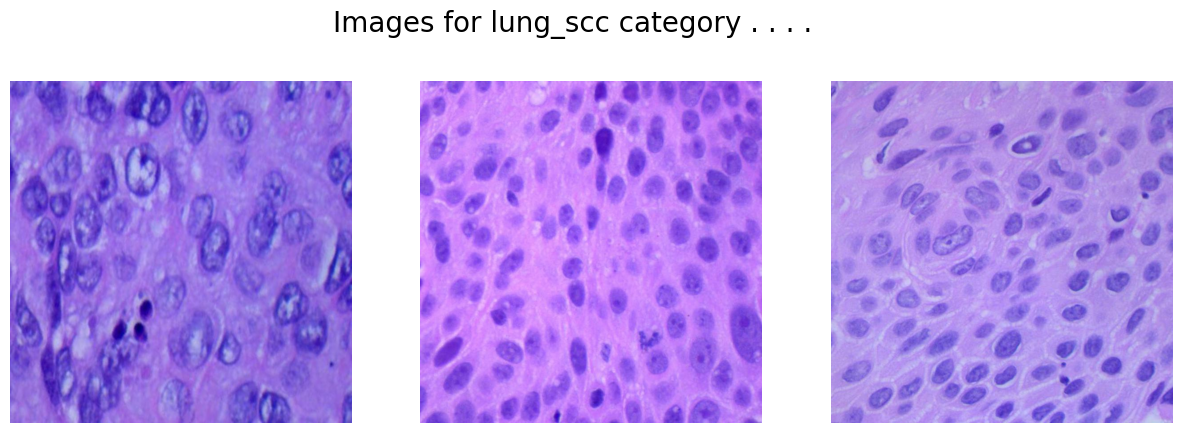

In [5]:
path = 'lung_colon_image_set/lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', 
                 fontsize = 20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [6]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [7]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)
    
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(
  X, one_hot_encoded_Y, test_size = SPLIT, random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    weights = 'imagenet',
    include_top = False
)


In [10]:
len(pre_trained_model.layers)


311

In [11]:
for layer in pre_trained_model.layers:
  layer.trainable = False


In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
output_shape = last_layer.input[0].shape 

print('last layer output shape: ', output_shape) 
last_output = last_layer.output

# This code is modified by Susobhan Akhuli


last layer output shape:  (None, 14, 14, 192)


In [13]:
x = layers.Flatten()(last_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)


In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)


In [ ]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.7978 - loss: 0.4865 - val_accuracy: 0.8983 - val_loss: 0.2469 - learning_rate: 0.0010
Epoch 2/10
 35/188 ━━━━━━━━━━━━━━━━━━━━ 2:58 1s/step - accuracy: 0.8864 - loss: 0.2693

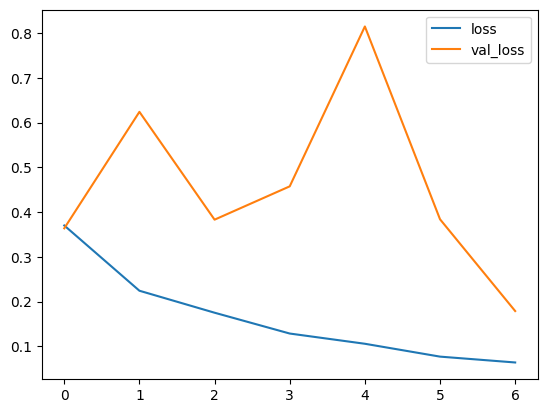

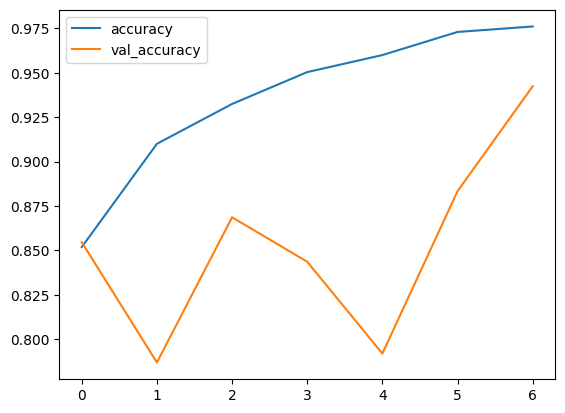

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [19]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step


In [20]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[ 857,    4,  126],
       [  24,  951,    2],
       [  16,    1, 1019]], dtype=int64)

In [21]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.96      0.87      0.91       987
      lung_n       0.99      0.97      0.98       977
    lung_scc       0.89      0.98      0.93      1036

    accuracy                           0.94      3000
   macro avg       0.95      0.94      0.94      3000
weighted avg       0.95      0.94      0.94      3000

